<a href="https://colab.research.google.com/github/RentoYabuki06/Born2beroot_42tokyo/blob/main/240613_%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96%E5%8B%89%E5%BC%B7%E4%BC%9A_%E7%AC%AC5%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **第5章 1つの車両を用いた多期間の配送計画**

### **5.1 導入**

- **配送計画問題（VRP: Vehicle Routing Problem)**：車両を用いて複数の荷物を配送する際の最適な経路を求める最適化問題

- **NP困難**：配送計画問題、巡回セールスマン問題

本章では、1つの車両を用いた多機関の配送計画問題を**混合整数計画（MIP: Mixed Integer Programming)問題**にモデリングして解く

以下3点を解説

- 巡回セールスマン問題の混合整数計画問題へのモデリング（MTZ定式化）
- 数理モデルの表現力を高める補助変数の使い方
- 配送パターンの列挙を利用した数理モデルの工夫による求解の効率化

以下の通り進める。2回サイクルをまわしているのがポイント

- 5.2: 課題整理
- 5.3: 混合整数計画問題として素朴に数理モデリング
- 5.4: 実装、実験、検証し、課題を発見
- 5.5: 課題を解決するために、工夫して数理モデリング
- 5.6: 実装、実験、検証
- 5.7: まとめ


### **5.2 課題整理**
#### ①配送計画の概要とアウトプットイメージ
##### 概要
- 配送車両：トラック1台
- 地点：配送拠点である配送センターが1箇所、配送先であるお店を複数持つ
- 配送ルート：配送センターを出発し、いくつかのお店を訪問して、配送センターに戻ってくるまでの配送の順番を表したもの。同じお店に2回以上訪問しない
- それぞれのお店には荷物を注文する
- 各荷物には配送期間と荷物の重量が指定されている

図は省略

##### アウトプットイメージ
- 配送計画：20日分の配送ルート、および各配送日にお店に配送する荷物が決定された表

表は省略

#### ②トラックに関する要件
- 1日に配送できる荷物の重量は4,000[kg]とする

#### ③ドライバーに関する要件
- ドライバーの所定労働時間は1日8時間とする
- ドライバーが所定労働時間を超えて配送業務を行う場合、1時間あたり3,000円の残業費用が発生する
- ドライバーの1日の残業時間は3時間以下とする

#### ④外部配送業者に関する要件

- 外注すると1[kg]あたり46円の外注費用が発生する

#### ⑤最適化の要件

目標：配送費用の最小化を目指し、「残業費用」と「外注費用」の和を最小化する


### **5.3 素朴な数理モデリング**

数理最適化問題のモデリング：集合、定数、変数、制約式、目的関数に分けて行う

入力データは、集合、定数なのでこちらを先に与えるとモデリングの見通しがよくなる。

#### 　①混合整数計画問題への素朴な数理モデリング

#####(1) 集合と定数

以下。詳細は書籍参照

- 期間
- 地点
- 移動時間
- 荷物
- その他、固定値の定数

##### (2) 決定変数と補助変数

- 決定変数（独立した変数として定義するもの）：地点間の移動の有無・荷物の自社配送の有無
- 補助変数（決定変数の従属して値が決まる変数）：移動する順番・残業時間

補助変数は一見すると無用に思えるが、現実の問題をソルバーで解くために必須のテクニック。一般的には「モデリングしたら問題が非線形になってしまって困った」ときに導入を検討するもの。

数式や詳細は書籍参照

##### (3) 制約式と目的関数

###### (A) サイクルとなる経路

現実的に移動可能な経路を表すために、制約式が必要

- (A-1) 各配送日について、ある地点に移動する数とその地点から移動する数は一致する
- (A-2) 各配送日について、地点に訪問する数は高々1回までとする

配送センターを通らないサイクルは配送ルートとならないので、次の(B)の制約が必要となる。

###### (B) 配送センターを出発するサイクル

- (B-1) 各配送日について、配送センターを出発地点（0番目に訪問）とする
- (B-2) 各配送日における、地点への訪問順番の上下限値
- (B-3) 各配送日について、お店間だけのサイクルを禁止する

(A)(B)のテクニックは巡回セールスマン問題のMTZ定式化（Miller-Tucker-Zemlin)で用いられる（後述）。

###### (C) 荷物を自社配送するなら期間内で高々一回

- 各荷物は、自社配送するなら期間内で高々一回までとする

###### (D) 荷物を自社配送するなら配送先のお店に訪問

- 各配送日について、荷物を自社配送するなら、配送先のお店に訪問する

###### (E) トラックの積載量

- 各配送日について、荷物の重量は4,000[kg]以下とする

###### (F) ドライバーの残業時間の定義

- 各配送日について、ドライバーの残業時間は所定労働時間の8時間を差し引いた労働時間となる


###### (G) ドライバーの残業時間の制約

- 各配送日について、ドライバーの残業時間は3時間以内とする

###### (H) 荷物は指定配送期間に配送

- (H-1) 各荷物は、開始日より前の配送を禁止する
- (H-2) 各荷物は、終了日より後の配送を禁止する

###### (I) 配送費用（残業費用 + 外注費用）の最小化

- (I) 配送費用（残業費用 + 外注費用）を最小化する


###### **☆素朴な数理モデル**

上記をまとめると素朴な数理モデルが得られる。

詳細は書籍を参照。


#### ②素朴な数理モデルの解説

初学者にとっては難しい内容で読み飛ばしてよいと書いてあるので、ありがたく読み飛ばす。

### **5.4 素朴な数理モデルの実装と実験**

#### ① 実行環境
データのダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/small_locations.csv
!wget https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/small_distances.csv
!wget https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/small_orders.csv
!wget https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/locations.csv
!wget https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/distances.csv
!wget https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/orders.csv

--2024-06-07 01:13:44--  https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/small_locations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘small_locations.csv’

small_locations.csv 100%[===================>]      63  --.-KB/s    in 0s      

2024-06-07 01:13:44 (1.12 MB/s) - ‘small_locations.csv’ saved [63/63]

--2024-06-07 01:13:45--  https://raw.githubusercontent.com/ohmsha/PyOptBook/main/5.routing_ver2/small_distances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388 [t

- location.csv: 地点のデータ
- distances.csv: 地点間の移動時間のデータ
- orders.csv: 荷物のデータ

ファイル名にsmall_という接頭辞がついているファイルは実装確認用の小規模なデータ

#### ② データの確認
小規模なデータで確認

##### small_locations.csv

- k: お店/配送センターのID
- x,y: お店/配送センターの座標
- depo_flag: 配送センターだと1,お店は0

In [ ]:
import pandas as pd
k_df = pd.read_csv('small_locations.csv')
print(len(k_df))
k_df.head()

5


,k,x,y,depo_flag
0,p,0,0,1
1,s1,-2,0,0
2,s2,-2,-2,0
3,s3,4,0,0
4,s4,4,2,0


可視化。配送センター(o)は原点。

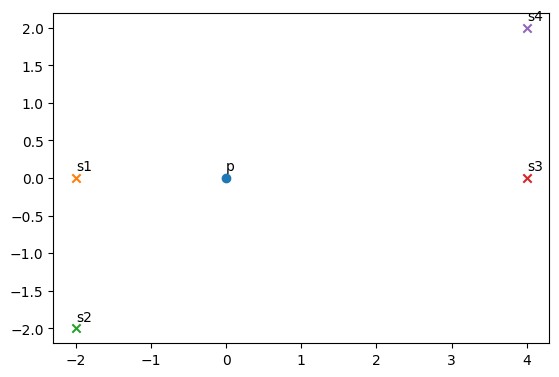

In [ ]:
import matplotlib.pyplot as plt

fig = plt.subplot()
fig.set_aspect('equal')

for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x,row.y+0.1))

plt.show()

##### small_locations.csv

- k1: 始点
- k2: 終点
- t: 時間

In [ ]:
kk_df = pd.read_csv('small_distances.csv')
print(len(kk_df))
kk_df.head()

25


,k1,k2,t
0,p,p,0.000000
1,p,s1,2.000000
2,p,s2,2.828427
3,p,s3,4.000000
4,p,s4,4.472136


##### small_orders.csv

- r: 荷物のID
- s: 注文したお店のID
- w: 荷物の重量[kg]
- b: 荷物を届けて欲しい期間の開始日[day]
- e: 荷物を届けて欲しい期間の終了日[day]

In [ ]:
r_df = pd.read_csv('small_orders.csv')
print(len(r_df))
r_df.head()

8


,r,s,w,b,e
0,r1,s1,1000,1,1
1,r2,s2,1000,1,2
2,r3,s3,1000,2,2
3,r4,s4,1500,2,3
4,r5,s1,1500,2,4


#### ③ 素朴な数理モデルの実装と確認（小規模データ）

配送日のリスト

In [ ]:
D = list(range(r_df.b.min(), r_df.e.max() + 1))
D

[1, 2, 3, 4]

配送センター

In [ ]:
p = k_df[k_df.depo_flag == 1].k.tolist()[0] # なんでわざわざ[0]を取り出してる？ → 後で使うからっぽい
p

'p'

お店のリスト

In [ ]:
S = k_df[k_df.depo_flag == 0].k.tolist()
S

['s1', 's2', 's3', 's4']

地点のリスト

In [ ]:
K = [p] + S
K

['p', 's1', 's2', 's3', 's4']

荷物のリスト

In [ ]:
R = r_df.r.tolist()
R

['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']

各変数を定義するために必要なリスト

In [ ]:
DKK = [(d,k1,k2) for d in D for k1 in K for k2 in K]
DKK[:5]

[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]

おまけ：頭が悪いので、これくらい冗長に書かないとパッとわからない…

In [ ]:
DKK_2 = []
for d in D:
    for k1 in K:
        for k2 in K:
            DKK_2.append((d, k1, k2))

DKK_2[:5]

[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]

In [ ]:
DR = [(d,r) for d in D for r in R]
DR[:5]

[(1, 'r1'), (1, 'r2'), (1, 'r3'), (1, 'r4'), (1, 'r5')]

In [ ]:
DK = [(d,k) for d in D for k in K]
DK[:5]

[(1, 'p'), (1, 's1'), (1, 's2'), (1, 's3'), (1, 's4')]

定数を辞書形式で作成。

- R2S: 荷物の配送先のお店を表す辞書
- R2W: 荷物の重量を表す辞書
- R2B: 荷物の指定配送期間の開始日を表す辞書
- R2E: 荷物の指定配送期間の終了日を表す辞書
- KK2T: 地点間の移動時間を表す辞書

In [ ]:
r_df.itertuples()

In [ ]:
R2S = {row.r:row.s for row in r_df.itertuples()}
R2S

{'r1': 's1',
 'r2': 's2',
 'r3': 's3',
 'r4': 's4',
 'r5': 's1',
 'r6': 's2',
 'r7': 's3',
 'r8': 's4'}

In [ ]:
R2W = {row.r:row.w for row in r_df.itertuples()}
R2W

{'r1': 1000,
 'r2': 1000,
 'r3': 1000,
 'r4': 1500,
 'r5': 1500,
 'r6': 1500,
 'r7': 1500,
 'r8': 3000}

In [ ]:
R2B = {row.r:row.b for row in r_df.itertuples()}
R2B

{'r1': 1, 'r2': 1, 'r3': 2, 'r4': 2, 'r5': 2, 'r6': 3, 'r7': 3, 'r8': 4}

In [ ]:
R2E = {row.r:row.e for row in r_df.itertuples()}
R2E

{'r1': 1, 'r2': 2, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 4, 'r7': 4, 'r8': 4}

In [ ]:
KK2T = {(row.k1, row.k2):row.t for row in kk_df.itertuples()}
KK2T

{('p', 'p'): 0.0,
 ('p', 's1'): 2.0,
 ('p', 's2'): 2.8284271247461903,
 ('p', 's3'): 4.0,
 ('p', 's4'): 4.47213595499958,
 ('s1', 'p'): 2.0,
 ('s1', 's1'): 0.0,
 ('s1', 's2'): 2.0,
 ('s1', 's3'): 6.0,
 ('s1', 's4'): 6.324555320336759,
 ('s2', 'p'): 2.8284271247461903,
 ('s2', 's1'): 2.0,
 ('s2', 's2'): 0.0,
 ('s2', 's3'): 6.324555320336759,
 ('s2', 's4'): 7.211102550927978,
 ('s3', 'p'): 4.0,
 ('s3', 's1'): 6.0,
 ('s3', 's2'): 6.324555320336759,
 ('s3', 's3'): 0.0,
 ('s3', 's4'): 2.0,
 ('s4', 'p'): 4.47213595499958,
 ('s4', 's1'): 6.324555320336759,
 ('s4', 's2'): 7.211102550927978,
 ('s4', 's3'): 2.0,
 ('s4', 's4'): 0.0}

**☆「素朴な数理モデル」の実装**

In [ ]:
!pip install -qq pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 41.2 MB/s eta 0:00:00


制約式を1つずつ追加して結果を吟味するような進め方が理想。

ここでは省略して一気に実装。

In [ ]:
import pulp

prob = pulp.LpProblem('vrp_small', pulp.LpMinimize)

x = pulp.LpVariable.dicts('x', DKK, cat='Binary')
u = pulp.LpVariable.dicts('u', DK, cat='Integer', lowBound=0)
y = pulp.LpVariable.dicts('y', DR, cat='Binary')
h = pulp.LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        # (A-1) 各配送日について、ある地点に移動する数とその地点から移動する数は一致
        prob += pulp.lpSum([x[d,k1,k2] for k2 in K]) == pulp.lpSum([x[d,k2,k1] for k2 in K])

        # (A-2) 各配送日について、地点に訪問する数は高々1回まで
        prob += pulp.lpSum([x[d,k2,k1] for k2 in K]) <= 1

for d in D:
    # (B-1) 各配送日について、配送センターは出発地点(0番目に訪問)
    prob += u[d,p] == 0

    # (B-2) 各配送日における、地点への訪問順番の上下限値
    for s in S:
        prob += 1 <= u[d,s]
        prob += u[d,s] <= len(K) - 1

    # (B-3) 各配送日について、お店間だけのサイクルを禁止
    for s1 in S:
        for s2 in S:
            prob += u[d,s1] + 1 <= u[d,s2] + (len(K) - 1) * (1 - x[d,s1,s2])

# (C) 各荷物は、自社配送するなら期間内で高々1回まで
for r in R:
    prob += pulp.lpSum([y[d,r] for d in D]) <= 1

# (D) 各配送日について、荷物を自社配送するなら、配送先のお店に訪問
for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d,r] <= pulp.lpSum(x[d,k,tar_s] for k in K)

# (E) 各配送日について、荷物の重量は4,000[kg]以下
for d in D:
    prob += pulp.lpSum([y[d,r] * R2W[r] for r in R]) <= 4000

# (F) 各配送日について、ドライバーの残業時間は所定労働時間の8時間を差し引いた労働時間
for d in D:
    prob += pulp.lpSum([KK2T[k1,k2] * x[d,k1,k2] for k1 in K for k2 in K]) - 8 <= h[d]

# (G) 各配送日について、ドライバーの残業時間は3時間以内
for d in D:
    prob += h[d] <= 3

# (H) 各荷物は指定配送期間外の配送を禁止
for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d,r] == 0
        if R2E[r] < d:
            prob += y[d,r] == 0

# (I) 配送費用（残業費用+外注費用）を最小化する
zangyo = pulp.lpSum([3000 * h[d] for d in D])
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d,r] for d in D)) for r in R])
prob += zangyo + gaityu

# 求解（明示的にCBCソルバーを指定する）
solver = pulp.PULP_CBC_CMD()
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))
print('外注費用:{:.0f}[円]'.format(gaityu.value()))
print('費用合計:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))

ステータス: Optimal
残業費用:10249[円]
外注費用:69000[円]
費用合計:79249[円]


コードのポイントは以下

```python
solver = pulp.PULP_CBC_CMD()
status = prob.solve(solver)
```

大きな問題のための準備。大きな問題のときにまた注意する。

配送日ごとの配送ルートを確認

In [ ]:
for d in D:
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value() == 1]

    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('---配送日:{}日目---'.format(d))
    print('配送重量:{}[kg]'.format(sum([y[d,r].value() * R2W[r] for r in R])))
    print('移動時間:{:.2f}[h]'.format(time))
    print('残業時間:{:.2f}[h]'.format(h[d].value()))
    print('x:', X)

    # 移動する地点の順番のリストを作成
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))

    print('Route:', Route)
    print('u:', [u[d,k].value() for k in Route])
    print('配送ルート:', '->'.join(Route) + '\n')

---配送日:1日目---
配送重量:2000.0[kg]
移動時間:6.83[h]
残業時間:0.00[h]
x: [('p', 's2'), ('s1', 'p'), ('s2', 's1')]
Route: ['p', 's2', 's1', 'p']
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s2->s1->p

---配送日:2日目---
配送重量:2500.0[kg]
移動時間:10.47[h]
残業時間:2.47[h]
x: [('p', 's3'), ('s3', 's4'), ('s4', 'p')]
Route: ['p', 's3', 's4', 'p']
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s3->s4->p

---配送日:3日目---
配送重量:3000.0[kg]
移動時間:6.83[h]
残業時間:0.00[h]
x: [('p', 's1'), ('s1', 's2'), ('s2', 'p')]
Route: ['p', 's1', 's2', 'p']
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s1->s2->p

---配送日:4日目---
配送重量:3000.0[kg]
移動時間:8.94[h]
残業時間:0.94[h]
x: [('p', 's4'), ('s4', 'p')]
Route: ['p', 's4', 'p']
u: [0.0, 1.0, 0.0]
配送ルート: p->s4->p



- トラックに積む荷物の重量は全て4,000[kg]以下
- 移動時間は全て 11時間（残業3時間）未満
- 配送ルートは「p,s2,s1,p」「p,s3,s4,p」「p,s1,s2,p」,「p,s4,p」であり、すべて「配送センターから出発してお店を訪問して、配送センターに戻ってくる」ルートである
- 補助変数uの値は訪問する順番を表している


荷物ごとの配送計画を確認する

In [ ]:
for r in R:
    # 自社トラックで配送したかどうかのフラグ
    owned_truck_flag = sum([y[d,r].value() for d in D])
    if owned_truck_flag:
        # 配送日の取得
        tar_d = [d for d in D if y[d,r].value() == 1][0]
        text = '荷物{}(お店{},{}[kg])-配送日:{}日目'.format(r, R2S[r], R2W[r], tar_d)
    else:
        # 外注費用の取得
        gc = 46 * R2W[r]
        text = '荷物{}(お店{},{}[kg])-外注費用:{}[円]'.format(r, R2S[r], R2W[r], gc)

    print(text)

荷物r1(お店s1,1000[kg])-配送日:1日目
荷物r2(お店s2,1000[kg])-配送日:1日目
荷物r3(お店s3,1000[kg])-配送日:2日目
荷物r4(お店s4,1500[kg])-配送日:2日目
荷物r5(お店s1,1500[kg])-配送日:3日目
荷物r6(お店s2,1500[kg])-配送日:3日目
荷物r7(お店s3,1500[kg])-外注費用:69000[円]
荷物r8(お店s4,3000[kg])-配送日:4日目


#### ④ 素朴な数理モデルの実験（中規模データ）

データを読み込む

In [ ]:
k_df = pd.read_csv('locations.csv')
print(len(k_df))
#k_df.head()
k_df

10


,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0
5,s5,0.225124,-0.395844,0
6,s6,-1.431318,-0.245852,0
7,s7,-0.430595,0.724166,0
8,s8,-1.997746,-0.840215,0
9,s9,1.381669,2.228797,0


可視化

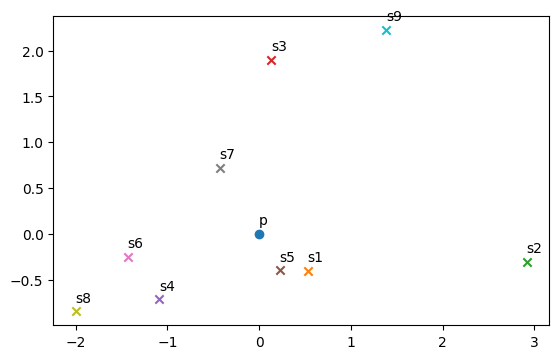

In [ ]:
fig = plt.subplot()
fig.set_aspect('equal')

for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x,row.y+0.1))

plt.show()

In [ ]:
kk_df = pd.read_csv('distances.csv')
print(len(kk_df))
kk_df.head()

100


,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570
3,p,s3,1.903527
4,p,s4,1.301730


In [ ]:
r_df = pd.read_csv('orders.csv')
print(len(r_df))
r_df.head()

100


,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2


集合と定数をあらためて準備

In [ ]:
# 配送日のリスト
D = list(range(r_df.b.min(), r_df.e.max() + 1))

# 配送センター
p = k_df[k_df.depo_flag == 1].k.tolist()[0]

# お店のリスト
S = k_df[k_df.depo_flag == 0].k.tolist()

# 地点のリスト
K = [p] + S

# 荷物のリスト
R = r_df.r.tolist()

# 各種変数を定義するために必要なリスト
DKK = [(d,k1,k2) for d in D for k1 in K for k2 in K]
DR = [(d,r) for d in D for r in R]
DK = [(d,k) for d in D for k in K]

#表示
print(D)
print(K)
print(R[:5])
print(DKK[:5])
print(DR[:5])
print(DK[:5])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['p', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9']
['r00', 'r01', 'r02', 'r03', 'r04']
[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]
[(1, 'r00'), (1, 'r01'), (1, 'r02'), (1, 'r03'), (1, 'r04')]
[(1, 'p'), (1, 's1'), (1, 's2'), (1, 's3'), (1, 's4')]


同様に辞書を作成

In [ ]:
# 荷物に紐づける配送先のお店
R2S = {row.r:row.s for row in r_df.itertuples()}

# 荷物に紐づける重量
R2W = {row.r:row.w for row in r_df.itertuples()}

# 荷物に紐づける指定配送期間の開始日
R2B = {row.r:row.b for row in r_df.itertuples()}

# 荷物に紐づける指定配送期間の終了日
R2E = {row.r:row.e for row in r_df.itertuples()}

# 地点の移動時間
KK2T = {(row.k1,row.k2):row.t for row in kk_df.itertuples()}

# 表示
print('R2S:', R2S)
print('R2W:', R2W)
print('R2B:', R2B)
print('R2E:', R2E)
print('KK2T:', KK2T)

R2S: {'r00': 's4', 'r01': 's1', 'r02': 's6', 'r03': 's5', 'r04': 's2', 'r05': 's5', 'r06': 's3', 'r07': 's4', 'r08': 's2', 'r09': 's6', 'r10': 's9', 'r11': 's3', 'r12': 's1', 'r13': 's7', 'r14': 's9', 'r15': 's3', 'r16': 's5', 'r17': 's7', 'r18': 's4', 'r19': 's9', 'r20': 's6', 'r21': 's8', 'r22': 's4', 'r23': 's9', 'r24': 's2', 'r25': 's3', 'r26': 's5', 'r27': 's5', 'r28': 's2', 'r29': 's4', 'r30': 's4', 'r31': 's1', 'r32': 's7', 'r33': 's8', 'r34': 's5', 'r35': 's6', 'r36': 's1', 'r37': 's7', 'r38': 's7', 'r39': 's2', 'r40': 's4', 'r41': 's3', 'r42': 's7', 'r43': 's5', 'r44': 's2', 'r45': 's9', 'r46': 's9', 'r47': 's7', 'r48': 's2', 'r49': 's9', 'r50': 's7', 'r51': 's7', 'r52': 's6', 'r53': 's9', 'r54': 's5', 'r55': 's5', 'r56': 's4', 'r57': 's8', 'r58': 's6', 'r59': 's3', 'r60': 's2', 'r61': 's7', 'r62': 's1', 'r63': 's5', 'r64': 's7', 'r65': 's8', 'r66': 's8', 'r67': 's1', 'r68': 's7', 'r69': 's2', 'r70': 's1', 'r71': 's2', 'r72': 's3', 'r73': 's3', 'r74': 's1', 'r75': 's2', 'r76':

☆素朴な数理モデルを再度実行。以下のコードは再掲（コピペ）

In [ ]:
import pulp

prob = pulp.LpProblem('vrp_small', pulp.LpMinimize)

x = pulp.LpVariable.dicts('x', DKK, cat='Binary')
u = pulp.LpVariable.dicts('u', DK, cat='Integer', lowBound=0)
y = pulp.LpVariable.dicts('y', DR, cat='Binary')
h = pulp.LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        # (A-1) 各配送日について、ある地点に移動する数とその地点から移動する数は一致
        prob += pulp.lpSum([x[d,k1,k2] for k2 in K]) == pulp.lpSum([x[d,k2,k1] for k2 in K])

        # (A-2) 各配送日について、地点に訪問する数は高々1回まで
        prob += pulp.lpSum([x[d,k2,k1] for k2 in K]) <= 1

for d in D:
    # (B-1) 各配送日について、配送センターは出発地点(0番目に訪問)
    prob += u[d,p] == 0

    # (B-2) 各配送日における、地点への訪問順番の上下限値
    for s in S:
        prob += 1 <= u[d,s]
        prob += u[d,s] <= len(K) - 1

    # (B-3) 各配送日について、お店間だけのサイクルを禁止
    for s1 in S:
        for s2 in S:
            prob += u[d,s1] + 1 <= u[d,s2] + (len(K) - 1) * (1 - x[d,s1,s2])

# (C) 各荷物は、自社配送するなら期間内で高々1回まで
for r in R:
    prob += pulp.lpSum([y[d,r] for d in D]) <= 1

# (D) 各配送日について、荷物を自社配送するなら、配送先のお店に訪問
for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d,r] <= pulp.lpSum(x[d,k,tar_s] for k in K)

# (E) 各配送日について、荷物の重量は4,000[kg]以下
for d in D:
    prob += pulp.lpSum([y[d,r] * R2W[r] for r in R]) <= 4000

# (F) 各配送日について、ドライバーの残業時間は所定労働時間の8時間を差し引いた労働時間
for d in D:
    prob += pulp.lpSum([KK2T[k1,k2] * x[d,k1,k2] for k1 in K for k2 in K]) - 8 <= h[d]

# (G) 各配送日について、ドライバーの残業時間は3時間以内
for d in D:
    prob += h[d] <= 3

# (H) 各荷物は指定配送期間外の配送を禁止
for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d,r] == 0
        if R2E[r] < d:
            prob += y[d,r] == 0

# (I) 配送費用（残業費用+外注費用）を最小化する
zangyo = pulp.lpSum([3000 * h[d] for d in D])
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d,r] for d in D)) for r in R])
prob += zangyo + gaityu

# 求解（明示的にCBCソルバーを指定する）
solver = pulp.PULP_CBC_CMD()
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))
print('外注費用:{:.0f}[円]'.format(gaityu.value()))
print('費用合計:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))

KeyboardInterrupt: 

計算量が多く、全く終わらない。

計算を打ち切るためのオプションを指定


代表的なオプションは以下2つ

**timeLimit: 計算時間による終了判定**

60秒で計算を打ち切る。

```python
solver = pulp.PULP_CBC_CMD(timeLimite=60)
```


**gapRel: 最適解となる目的関数値からの誤差による終了判定**

離村的な最適解の目的関数値に対して10%以内の誤差の目的関数値の解が得られたら打ち切り。

```python
solver = pulp.PULP_CBC_CMD(gapRel=0.1)
```

誤差による終了判定を入れて再度実行

In [ ]:
import pulp

prob = pulp.LpProblem('vrp_small', pulp.LpMinimize)

x = pulp.LpVariable.dicts('x', DKK, cat='Binary')
u = pulp.LpVariable.dicts('u', DK, cat='Integer', lowBound=0)
y = pulp.LpVariable.dicts('y', DR, cat='Binary')
h = pulp.LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        # (A-1) 各配送日について、ある地点に移動する数とその地点から移動する数は一致
        prob += pulp.lpSum([x[d,k1,k2] for k2 in K]) == pulp.lpSum([x[d,k2,k1] for k2 in K])

        # (A-2) 各配送日について、地点に訪問する数は高々1回まで
        prob += pulp.lpSum([x[d,k2,k1] for k2 in K]) <= 1

for d in D:
    # (B-1) 各配送日について、配送センターは出発地点(0番目に訪問)
    prob += u[d,p] == 0

    # (B-2) 各配送日における、地点への訪問順番の上下限値
    for s in S:
        prob += 1 <= u[d,s]
        prob += u[d,s] <= len(K) - 1

    # (B-3) 各配送日について、お店間だけのサイクルを禁止
    for s1 in S:
        for s2 in S:
            prob += u[d,s1] + 1 <= u[d,s2] + (len(K) - 1) * (1 - x[d,s1,s2])

# (C) 各荷物は、自社配送するなら期間内で高々1回まで
for r in R:
    prob += pulp.lpSum([y[d,r] for d in D]) <= 1

# (D) 各配送日について、荷物を自社配送するなら、配送先のお店に訪問
for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d,r] <= pulp.lpSum(x[d,k,tar_s] for k in K)

# (E) 各配送日について、荷物の重量は4,000[kg]以下
for d in D:
    prob += pulp.lpSum([y[d,r] * R2W[r] for r in R]) <= 4000

# (F) 各配送日について、ドライバーの残業時間は所定労働時間の8時間を差し引いた労働時間
for d in D:
    prob += pulp.lpSum([KK2T[k1,k2] * x[d,k1,k2] for k1 in K for k2 in K]) - 8 <= h[d]

# (G) 各配送日について、ドライバーの残業時間は3時間以内
for d in D:
    prob += h[d] <= 3

# (H) 各荷物は指定配送期間外の配送を禁止
for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d,r] == 0
        if R2E[r] < d:
            prob += y[d,r] == 0

# (I) 配送費用（残業費用+外注費用）を最小化する
zangyo = pulp.lpSum([3000 * h[d] for d in D])
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d,r] for d in D)) for r in R])
prob += zangyo + gaityu

# 求解（明示的にCBCソルバーを指定する）
solver = pulp.PULP_CBC_CMD(gapRel=0.1) #誤差による終了判定を追加
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))
print('外注費用:{:.0f}[円]'.format(gaityu.value()))
print('費用合計:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))

ステータス: Optimal
残業費用:27003[円]
外注費用:1208420[円]
費用合計:1235423[円]


配送ルートを確認する

In [ ]:
for d in D:
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value()==1]

    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('---配送日:{}日目---'.format(d))
    print('配送重量:{}[kg]'.format(sum([y[d,r].value() * R2W[r] for r in R])))
    print('移動時間:{:.2f}[h]'.format(time))
    print('残業時間:{:.2f}[h]'.format(h[d].value()))

    # 移動する地点の順番のリストを作成
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))

    print('配送ルート:', '->'.join(Route), '\n')

---配送日:1日目---
配送重量:3680.0[kg]
移動時間:5.82[h]
残業時間:0.00[h]
配送ルート: p->s3->s9->p 

---配送日:2日目---
配送重量:3940.0[kg]
移動時間:7.60[h]
残業時間:0.00[h]
配送ルート: p->s4->s8->s6->s3->p 

---配送日:3日目---
配送重量:3850.0[kg]
移動時間:5.37[h]
残業時間:0.00[h]
配送ルート: p->s5->s4->s6->s8->p 

---配送日:4日目---
配送重量:3960.0[kg]
移動時間:6.67[h]
残業時間:0.00[h]
配送ルート: p->s4->s6->s8->s7->s5->p 

---配送日:5日目---
配送重量:3980.0[kg]
移動時間:7.18[h]
残業時間:0.00[h]
配送ルート: p->s9->s3->s5->s1->p 

---配送日:6日目---
配送重量:3560.0[kg]
移動時間:6.73[h]
残業時間:0.00[h]
配送ルート: p->s5->s7->s9->p 

---配送日:7日目---
配送重量:3770.0[kg]
移動時間:6.29[h]
残業時間:0.00[h]
配送ルート: p->s1->s5->s4->s8->s7->p 

---配送日:8日目---
配送重量:4000.0[kg]
移動時間:8.51[h]
残業時間:0.51[h]
配送ルート: p->s1->s2->s3->p 

---配送日:9日目---
配送重量:3880.0[kg]
移動時間:9.33[h]
残業時間:1.33[h]
配送ルート: p->s2->s9->s3->s7->p 

---配送日:10日目---
配送重量:3890.0[kg]
移動時間:9.21[h]
残業時間:1.21[h]
配送ルート: p->s7->s9->s2->s1->p 

---配送日:11日目---
配送重量:3100.0[kg]
移動時間:8.28[h]
残業時間:0.28[h]
配送ルート: p->s4->s5->s1->s2->p 

---配送日:12日目---
配送重量:3810.0[kg]
移動時間:3.08[h]
残業時間:0.00[h]
配送ル

荷物ごとの結果を確認

In [ ]:
for r in R:
    # 自社のトラックで配送したかどうかのフラグ
    owned_truck_flag = sum([y[d,r].value() for d in D])
    if owned_truck_flag:
        # 配送日の取得
        tar_d = [d for d in D if y[d,r].value() == 1][0]
        text = '荷物{}(お店{},{}[kg])-配送日:{}日目'.format(r, R2S[r], R2W[r], tar_d)
    else:
        # 外注費用の取得
        gc = 46 * R2W[r]
        text = '荷物{}(お店{},{}[kg])-外注費用:{}[円]'.format(r, R2S[r], R2W[r], gc)

    print(text)

荷物r00(お店s4,1000[kg])-配送日:17日目
荷物r01(お店s1,950[kg])-外注費用:43700[円]
荷物r02(お店s6,1330[kg])-配送日:2日目
荷物r03(お店s5,1130[kg])-配送日:19日目
荷物r04(お店s2,710[kg])-外注費用:32660[円]
荷物r05(お店s5,690[kg])-配送日:11日目
荷物r06(お店s3,1180[kg])-配送日:13日目
荷物r07(お店s4,690[kg])-配送日:4日目
荷物r08(お店s2,960[kg])-外注費用:44160[円]
荷物r09(お店s6,930[kg])-配送日:14日目
荷物r10(お店s9,910[kg])-外注費用:41860[円]
荷物r11(お店s3,1100[kg])-配送日:8日目
荷物r12(お店s1,1360[kg])-配送日:12日目
荷物r13(お店s7,1120[kg])-外注費用:51520[円]
荷物r14(お店s9,820[kg])-配送日:9日目
荷物r15(お店s3,650[kg])-配送日:16日目
荷物r16(お店s5,1590[kg])-配送日:17日目
荷物r17(お店s7,930[kg])-配送日:15日目
荷物r18(お店s4,880[kg])-配送日:14日目
荷物r19(お店s9,1470[kg])-配送日:9日目
荷物r20(お店s6,1020[kg])-配送日:3日目
荷物r21(お店s8,2020[kg])-外注費用:92920[円]
荷物r22(お店s4,790[kg])-配送日:11日目
荷物r23(お店s9,890[kg])-配送日:6日目
荷物r24(お店s2,1160[kg])-配送日:16日目
荷物r25(お店s3,560[kg])-配送日:2日目
荷物r26(お店s5,1440[kg])-外注費用:66240[円]
荷物r27(お店s5,900[kg])-配送日:6日目
荷物r28(お店s2,1230[kg])-配送日:15日目
荷物r29(お店s4,1020[kg])-配送日:4日目
荷物r30(お店s4,1020[kg])-外注費用:46920[円]
荷物r31(お店s1,1080[kg])-配送日:7日目
荷物r32(お店s7,1110[kg])-配送日:1

日付ごとにチェック

In [ ]:
for d in [1, 2, 3]:
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value()==1]

    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('---配送日:{}日目---'.format(d))
    print('配送重量:{}[kg]'.format(sum([y[d,r].value() * R2W[r] for r in R])))
    print('移動時間:{:.2f}[h]'.format(time))
    print('残業時間:{:.2f}[h]'.format(h[d].value()))

    # 移動する地点の順番のリストを作成
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))

    print('配送ルート:', '->'.join(Route), '\n')

    for r in R:
        # 自社のトラックで配送したかどうかのフラグ
        owned_truck_flag = sum([y[d,r].value() for d in D])
        if owned_truck_flag:
            # 配送日の取得
            tar_d = [d for d in D if y[d,r].value() == 1][0]
            text = '荷物{}(お店{},{}[kg])-配送日:{}日目'.format(r, R2S[r], R2W[r], tar_d)

        if tar_d == d:
            print(text)

    print('\n')

---配送日:1日目---
配送重量:3680.0[kg]
移動時間:5.82[h]
残業時間:0.00[h]
配送ルート: p->s3->s9->p 

荷物r46(お店s9,1060[kg])-配送日:1日目
荷物r53(お店s9,890[kg])-配送日:1日目
荷物r53(お店s9,890[kg])-配送日:1日目
荷物r77(お店s3,880[kg])-配送日:1日目
荷物r99(お店s9,850[kg])-配送日:1日目


---配送日:2日目---
配送重量:3940.0[kg]
移動時間:7.60[h]
残業時間:0.00[h]
配送ルート: p->s4->s8->s6->s3->p 

荷物r02(お店s6,1330[kg])-配送日:2日目
荷物r25(お店s3,560[kg])-配送日:2日目
荷物r25(お店s3,560[kg])-配送日:2日目
荷物r57(お店s8,880[kg])-配送日:2日目
荷物r65(お店s8,1170[kg])-配送日:2日目
荷物r65(お店s8,1170[kg])-配送日:2日目


---配送日:3日目---
配送重量:3850.0[kg]
移動時間:5.37[h]
残業時間:0.00[h]
配送ルート: p->s5->s4->s6->s8->p 

荷物r20(お店s6,1020[kg])-配送日:3日目
荷物r20(お店s6,1020[kg])-配送日:3日目
荷物r78(お店s4,1270[kg])-配送日:3日目
荷物r80(お店s6,1560[kg])-配送日:3日目




配送の必要がないお店に寄り道している

e.g. 2日目 s4, 3日目 s5

問題を調査する。ルートの中に荷物のないお店への訪問がどのくらいあるかを確認。

In [ ]:
# 各配送日に対して、配送したお店を紐づける辞書の作成
resD2S = {d:set() for d in D}
for d,r in y:
    if y[d,r].value() == 1:
        resD2S[d].add(R2S[r])

for d in D:
    print('---配送日:{}日目---'.format(d))
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value() == 1]
    time = sum([KK2T[k1,k2] for k1,k2 in X])
    print('移動時間:{:.2f}[h]'.format(time))
    routeS = set([k1 for k1,k2 in X]) - set([p])
    print('(A)配送ルートのお店:', routeS)
    targetS = resD2S[d]
    print('(B)荷物の注文があるお店:', targetS)

    print('(A)-(B):', routeS - targetS)

---配送日:1日目---
移動時間:5.82[h]
(A)配送ルートのお店: {'s3', 's9'}
(B)荷物の注文があるお店: {'s3', 's9'}
(A)-(B): set()
---配送日:2日目---
移動時間:7.60[h]
(A)配送ルートのお店: {'s4', 's6', 's8', 's3'}
(B)荷物の注文があるお店: {'s3', 's8', 's6'}
(A)-(B): {'s4'}
---配送日:3日目---
移動時間:5.37[h]
(A)配送ルートのお店: {'s4', 's6', 's5', 's8'}
(B)荷物の注文があるお店: {'s4', 's6'}
(A)-(B): {'s5', 's8'}
---配送日:4日目---
移動時間:6.67[h]
(A)配送ルートのお店: {'s5', 's4', 's7', 's8', 's6'}
(B)荷物の注文があるお店: {'s4', 's7', 's6'}
(A)-(B): {'s5', 's8'}
---配送日:5日目---
移動時間:7.18[h]
(A)配送ルートのお店: {'s3', 's1', 's5', 's9'}
(B)荷物の注文があるお店: {'s9', 's1', 's5', 's3'}
(A)-(B): set()
---配送日:6日目---
移動時間:6.73[h]
(A)配送ルートのお店: {'s7', 's5', 's9'}
(B)荷物の注文があるお店: {'s7', 's5', 's9'}
(A)-(B): set()
---配送日:7日目---
移動時間:6.29[h]
(A)配送ルートのお店: {'s5', 's4', 's7', 's8', 's1'}
(B)荷物の注文があるお店: {'s7', 's1', 's8'}
(A)-(B): {'s4', 's5'}
---配送日:8日目---
移動時間:8.51[h]
(A)配送ルートのお店: {'s1', 's2', 's3'}
(B)荷物の注文があるお店: {'s1', 's2', 's3'}
(A)-(B): set()
---配送日:9日目---
移動時間:9.33[h]
(A)配送ルートのお店: {'s3', 's7', 's2', 's9'}
(B)荷物の注文があるお店: {'s7

問題ありあり。

要件で費用ばかりに注目していて**移動時間の最小化が入っていなかったことが要因**。

配送ルートも可視化

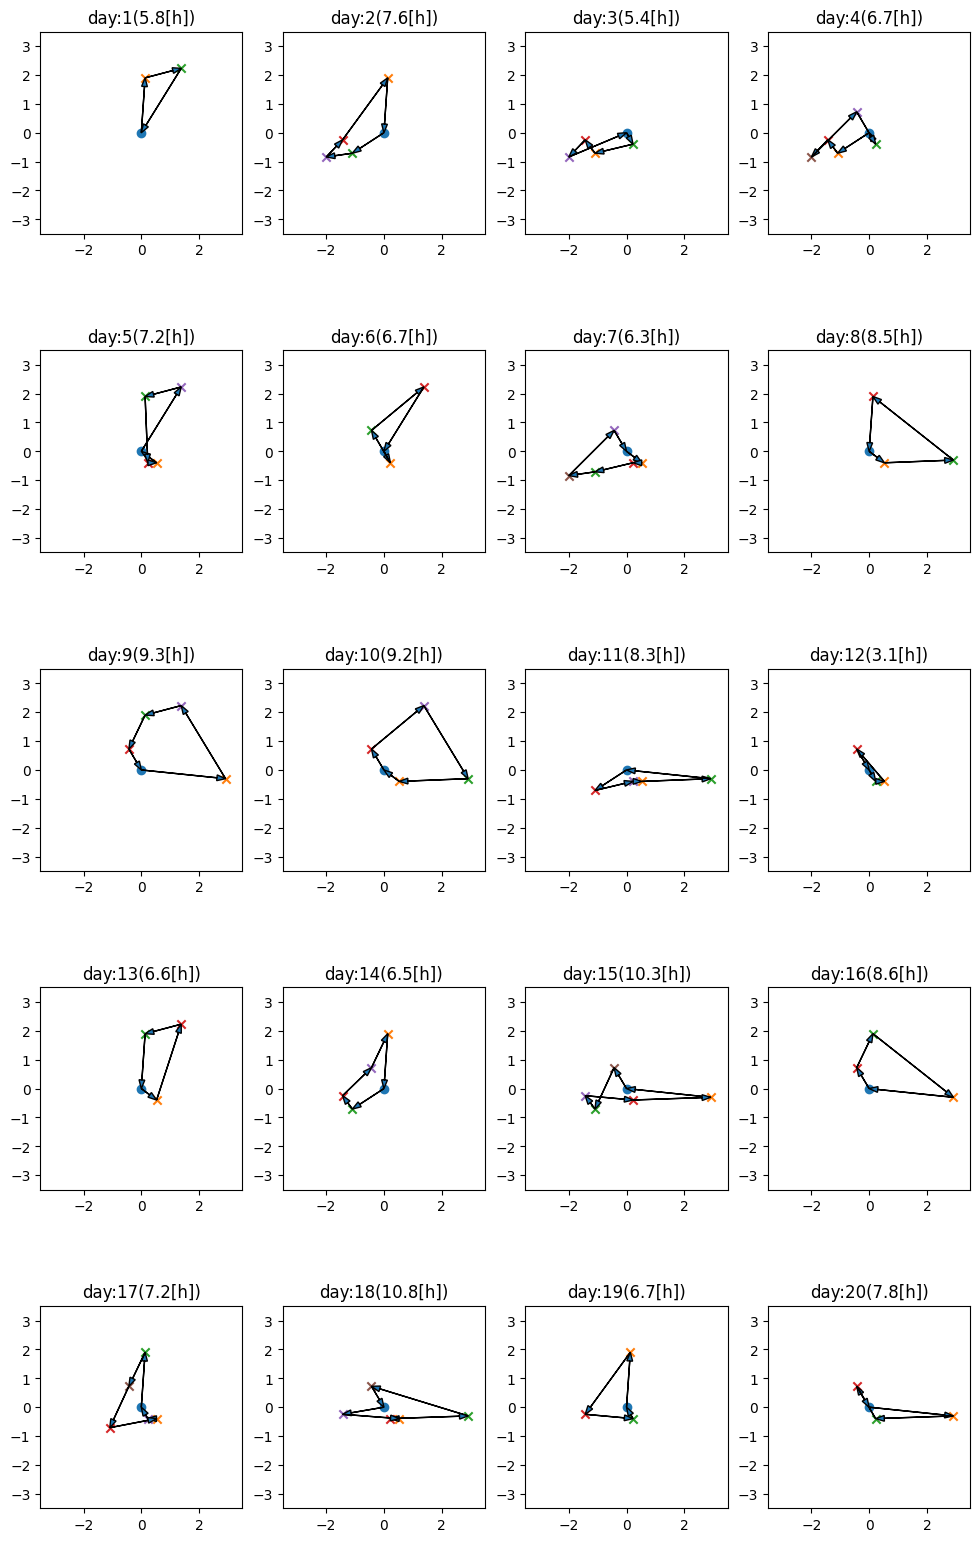

In [ ]:
import matplotlib.pyplot as plt

# 各地点の座標の取得
K2XY = {row.k:(row.x,row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(12,20))
for i in range(len(D)):
    d = D[i]
    X = [(k1,k2) for k1 in K for k2 in K if x[d,k1,k2].value() == 1]
    routeK = [k1 for k1,k2 in X]
    time = sum(KK2T[k1,k2] for k1,k2 in X)
    title_text = 'day:{}({:.1f}[h])'.format(d, time)
    ax = fig.add_subplot(
            5, 4, i + 1,
            xlim=(-3.5, 3.5),
            ylim=(-3.5, 3.5),
            title=title_text)
    ax.set_aspect('equal')

    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker='o')
            else:
                ax.scatter(row.x, row.y, marker='x')

    for k1,k2 in X:
        (x1,y1) = K2XY[k1]
        (x2,y2) = K2XY[k2]
        ax.arrow(x1, y1, (x2 - x1), (y2 - y1),
                head_width=0.2,
                length_includes_head=True)

交差していて、最短経路を得られてなさそう（最短経路は交差がない）

以下改善したい

- 計算効率改善
- 最短経路の選定
- 荷物の注文がないお店の訪問をなくす
- 移動時間（=労働時間）の最小化

### **5.5 配送パターンを利用したモデリング**

「効率的な配送パターン」を定義

- (ⅰ) 配送ルートは最短経路である
- (ⅱ) 配送ルートの移動時間は11[時間]以下（所定労働時間8時間＋最大残業時間3時間）
- (ⅲ) 荷物の重量は4,000[kg]以下
- (ⅳ) 荷物を配送しないお店に訪問する配送ルートは選択しない

各配送日に効率的な配送パターンを列挙。各配送日にどの配送パターンを選択するかという問題に置き換える。


#### ① 集合と定数

数理モデリングに必要な集合と定数

以下の通り。詳細は書籍参照
- 配送日の集合
- 荷物の集合
- 残業費用
- 外注費用

配送パターンに関する集合と定数を定義


- 各配送日の配送パターンの集合
- 各荷物を配送する配送パターンの集合

各配送日の効率的な配送パターンに対して決まる移動時間と残業時間を考える

- 各配送日の配送パターンの集合を結合した集合
- 各配送パターンの移動時間
- 各配送パターンの残業時間

#### ② 決定変数と補助変数

- 各配送日の配送パターンの選択を表す決定変数
- 荷物の外注の有無を表す補助変数

#### ③ 制約と目的関数
##### (A') 配送パターンの選択
- 各配送日に1つの配送パターンを選択する

あらかじめ効率的な配送パターンを列挙しているので、いずれの配送パターンを選択しても要件は満たされる。

##### (B') 外注と自社配送の選択

- 各荷物は外注するか自社配送のどちらかを選択する

##### (C') 配送費用の最小化と移動時間の最小化

- 目的関数（最小化）：数式は書籍参照

コストだけでなく、時間も最小化している。



**★配送パターンを利用した数理モデル**

書籍参照

### **5.6 配送パターンを利用した数理モデルの実装**

#### **① 効率的な配送パターンの列挙**

以下2つを定義

**実行可能な配送ルート**
- (ⅰ) 配送ルートは最短経路である
- (ⅱ) 配送ルートの移動時間は11時間以下

**効率的な配送パターン**

実行可能な配送ルートで、かつ以下の(ⅲ)と(ⅳ)を満たす
- (ⅲ) 荷物の重量は 4,000[kg]以下
- (ⅳ) 荷物を配送しないお店に訪問するルートは選択しない

2つのステップで効率的な配送パターンを列挙する

**ステップ1 実行可能な配送ルートの列挙**

データの読み込み

In [ ]:
import pandas as pd
k_df = pd.read_csv('locations.csv')
kk_df = pd.read_csv('distances.csv')
r_df = pd.read_csv('orders.csv')

D = list(range(r_df.b.min(), r_df.e.max() + 1))
p = k_df[k_df.depo_flag == 1].k.tolist()[0]
S = k_df[k_df.depo_flag == 0].k.tolist()
K = [p] + S
R = r_df.r.tolist()

R2S = {row.r:row.s for row in r_df.itertuples()}
R2W = {row.r:row.w for row in r_df.itertuples()}
R2B = {row.r:row.b for row in r_df.itertuples()}
R2E = {row.r:row.e for row in r_df.itertuples()}
KK2T = {(row.k1,row.k2):row.t for row in kk_df.itertuples()}

巡回セールスマン問題を解く関数を定義。

素朴な数理モデルの部分的な問題を解く数理モデル。目的関数が最短経路となる配送ルートを求めるように変更されている。

In [ ]:
import pulp

def tsp(p_, S_, KK2T_):
    K = [p_] + S_
    KK = [(k1,k2) for k1 in K for k2 in K]
    prob = pulp.LpProblem('tsp', pulp.LpMinimize)
    x = pulp.LpVariable.dicts('x', KK, cat='Binary')
    u = pulp.LpVariable.dicts('u', K, cat='Integer', lowBound=0)

    # 各地点に必ず1回訪問する
    for k1 in K:
        prob += pulp.lpSum([x[k1,k2] for k2 in K]) == 1
        prob += pulp.lpSum([x[k2,k1] for k2 in K]) == 1

    # (B-1)
    prob += u[p_] == 0

    # (B-2)
    for s in S_:
        prob += 1 <= u[s]
        prob += u[s] <= len(K) - 1

    # (B-3)
    for s1 in S_:
        for s2 in S_:
            prob += u[s1] + 1 <= u[s2] + (len(K) - 1) * (1 - x[s1,s2])

    # 移動時間は11時間以内
    prob += pulp.lpSum([KK2T_[k1,k2] * x[k1,k2] for k1 in K for k2 in K]) <= 11

    # 目的関数は移動時間の最小化
    prob += pulp.lpSum([KK2T_[k1,k2] * x[k1,k2] for k1 in K for k2 in K])

    solver = pulp.PULP_CBC_CMD(msg=0)
    status = prob.solve(solver)

    if status == 1:
        X = [(k1,k2) for k1 in K for k2 in K if x[k1,k2].value() == 1]
        time = sum([KK2T_[k1,k2] for k1,k2 in X])
    else:
        X = []
        time = -1
    return status, X, time

関数のテストを実行

In [ ]:
testS = ['s4', 's5', 's9']
status, X, time = tsp(p, testS, KK2T)
print('ステータス:', pulp.LpStatus[status])
print('x:', X)
print('移動時間:', time)

ステータス: Optimal
x: [('p', 's4'), ('s4', 's5'), ('s5', 's9'), ('s9', 'p')]
移動時間: 8.145373915498993


解けている。

In [ ]:
testS = ['s1', 's2', 's3', 's4', 's5', 's9']
status, X, time = tsp(p, testS, KK2T)
print('ステータス:', pulp.LpStatus[status])
print('x:', X)
print('移動時間:', time)

ステータス: Infeasible
x: []
移動時間: -1


解がない。

解がない配送ルートは排除できる。

実行可能な配送ルートを算出する。

具体的には、お店を訪問する配送ルートと移動時間とを紐づける辞書 `Stp2Pat`を作成する。

In [ ]:
from itertools import combinations

Stp2Pat = {}
for n in range(len(S) + 1):
    # お店の集合Sからn個選ぶ組合せを列挙
    count = 0
    for Stp in combinations(S, n): # 辞書式で列挙される
        # 配送センターpとn個のお店(Stp)の巡回セールスマン問題を解く
        status, X, time = tsp(p, list(Stp), KK2T)

        # 解が存在するときのみ配送ルートとして採用
        if status == 1:
            Stp2Pat[Stp] = (X, time)
            count += 1
    print('訪問するお店の数:{} 配送ルート数:{}'.format(n, count))
print('要件(ⅰ)(ⅱ)を満たす配送ルート数:', len(Stp2Pat))

訪問するお店の数:0 配送ルート数:1
訪問するお店の数:1 配送ルート数:9
訪問するお店の数:2 配送ルート数:36
訪問するお店の数:3 配送ルート数:81
訪問するお店の数:4 配送ルート数:107
訪問するお店の数:5 配送ルート数:83
訪問するお店の数:6 配送ルート数:37
訪問するお店の数:7 配送ルート数:9
訪問するお店の数:8 配送ルート数:1
訪問するお店の数:9 配送ルート数:0
要件(ⅰ)(ⅱ)を満たす配送ルート数: 364


Stp2Patの中身を確認。

In [ ]:
for i, (Stp,Pat) in enumerate(Stp2Pat.items()):
    if i>3:break
    print('---お店の組合せ:', Stp)
    print('配送ルート:', Pat)

---お店の組合せ: ()
配送ルート: ([('p', 'p')], 0.0)
---お店の組合せ: ('s1',)
配送ルート: ([('p', 's1'), ('s1', 'p')], 1.3236097970929661)
---お店の組合せ: ('s2',)
配送ルート: ([('p', 's2'), ('s2', 'p')], 5.865139919138787)
---お店の組合せ: ('s3',)
配送ルート: ([('p', 's3'), ('s3', 'p')], 3.807054271558092)


書籍ではさらなる高速化のアイデアも示されているが、ここでは割愛

**ステップ2 効率的な配送パターンの列挙**

各配送日に配送可能な荷物に着目し、要件（ⅲ）を満たす荷物の組み合わせを列挙。

荷物の組み合わせが決まれば、訪問するお店も決まるので、1つめのステップで得られた「実行可能な配送ルート」と称号することで、要件（ⅳ）を満たす効率的な配送パターンを得ることができる。

以下は再掲

**実行可能な配送ルート**
- (ⅰ) 配送ルートは最短経路である
- (ⅱ) 配送ルートの移動時間は11時間以下

**効率的な配送パターン**

実行可能な配送ルートで、かつ以下の(ⅲ)と(ⅳ)を満たす
- (ⅲ) 荷物の重量は 4,000[kg]以下
- (ⅳ) 荷物を配送しないお店に訪問するルートは選択しない


In [ ]:
# 配送日に対して配送可能な荷物のリストを紐づける辞書
D2R = {d:[] for d in D}
for r in R:
    for d in range(R2B[r], R2E[r] + 1):
        D2R[d].append(r)

# 各配送日に配送可能な荷物のリスト
for d in D:
    print('配送日:', d, D2R[d])

配送日: 1 ['r04', 'r46', 'r53', 'r77', 'r99']
配送日: 2 ['r02', 'r04', 'r20', 'r25', 'r46', 'r47', 'r53', 'r57', 'r65', 'r77', 'r78', 'r80', 'r99']
配送日: 3 ['r02', 'r20', 'r25', 'r46', 'r47', 'r53', 'r57', 'r65', 'r77', 'r78', 'r80', 'r99']
配送日: 4 ['r02', 'r07', 'r20', 'r29', 'r47', 'r56', 'r57', 'r93', 'r96']
配送日: 5 ['r07', 'r23', 'r29', 'r56', 'r73', 'r74', 'r79', 'r93', 'r96']
配送日: 6 ['r07', 'r23', 'r27', 'r31', 'r43', 'r44', 'r54', 'r56', 'r64', 'r67', 'r73', 'r74', 'r79', 'r81']
配送日: 7 ['r23', 'r27', 'r31', 'r33', 'r43', 'r44', 'r54', 'r64', 'r66', 'r67', 'r74', 'r79', 'r81', 'r90', 'r91']
配送日: 8 ['r11', 'r27', 'r31', 'r32', 'r33', 'r44', 'r51', 'r54', 'r66', 'r67', 'r75', 'r81', 'r82', 'r90', 'r91']
配送日: 9 ['r11', 'r14', 'r19', 'r32', 'r48', 'r51', 'r66', 'r75', 'r82', 'r90', 'r91']
配送日: 10 ['r05', 'r14', 'r19', 'r22', 'r32', 'r37', 'r48', 'r51', 'r69', 'r84', 'r98']
配送日: 11 ['r05', 'r22', 'r36', 'r37', 'r48', 'r69', 'r71', 'r84', 'r98']
配送日: 12 ['r05', 'r12', 'r36', 'r37', 'r71', 'r98'

以下2つで効率的な配送パターンを抽出

- 4,000[kg]以下の組み合わせを抽出
- 実行可能な配送ルートに限定

In [ ]:
# 各配送日に紐づける効率的な配送パターンのリスト
D2Pat = {d:[] for d in D}
for d in D:
    # 配送日dに配送可能な荷物のリストを作成
    dayR = D2R[d]

    # 荷物のリストの部分集合を列挙
    for n in range(len(dayR) + 1):
        for tarR in combinations(dayR, n):

            # 要件(iii):荷物の重量の確認
            w = sum([R2W[r] for r in tarR])
            if w > 4000:
                continue

            # 荷物の配送先のお店を抽出
            tarS = set([R2S[r] for r in tarR])
            tarStp = tuple(sorted(tarS))

            # 要件(iv):実行可能な配送ルートとの照合
            if tarStp in Stp2Pat:
                X, time = Stp2Pat[tarStp]
                pat = (X,time,list(tarR))
                D2Pat[d].append(pat)
            else:
                continue
    print('配送日:{} 配送パターン数:{}'.format(d, len(D2Pat[d])))

配送日:1 配送パターン数:31
配送日:2 配送パターン数:614
配送日:3 配送パターン数:503
配送日:4 配送パターン数:269
配送日:5 配送パターン数:260
配送日:6 配送パターン数:1371
配送日:7 配送パターン数:1143
配送日:8 配送パターン数:1461
配送日:9 配送パターン数:332
配送日:10 配送パターン数:345
配送日:11 配送パターン数:175
配送日:12 配送パターン数:44
配送日:13 配送パターン数:93
配送日:14 配送パターン数:333
配送日:15 配送パターン数:557
配送日:16 配送パターン数:2737
配送日:17 配送パターン数:3292
配送日:18 配送パターン数:2416
配送日:19 配送パターン数:2244
配送日:20 配送パターン数:575


#### **② 配送パターンを利用した数理モデルの実装・実験・検証**

In [ ]:
# 配送日に、配送可能な配送パターンのリストを紐づける辞書
D2Q = {d:[] for d in D}

# 配送パターンに、配送可能な荷物のリストを紐づける辞書
Q2R = {}

# 配送パターンに、移動時間を紐づける辞書
Q2T = {}

# 配送パターンに、残業時間を紐づける辞書
Q2H = {}

# 配送パターンに、配送ルートを紐づける辞書
Q2X = {}

for d in D:
    for q_no, (X,time,tarR) in enumerate(D2Pat[d]):
        q = 'q_{}_{}'.format(d, q_no)
        D2Q[d].append(q)
        Q2R[q] = tarR
        Q2T[q] = time
        Q2H[q] = max(time - 8, 0)
        Q2X[q] = X
print('配送日1日目の配送パターン:', D2Q[1])

配送日1日目の配送パターン: ['q_1_0', 'q_1_1', 'q_1_2', 'q_1_3', 'q_1_4', 'q_1_5', 'q_1_6', 'q_1_7', 'q_1_8', 'q_1_9', 'q_1_10', 'q_1_11', 'q_1_12', 'q_1_13', 'q_1_14', 'q_1_15', 'q_1_16', 'q_1_17', 'q_1_18', 'q_1_19', 'q_1_20', 'q_1_21', 'q_1_22', 'q_1_23', 'q_1_24', 'q_1_25', 'q_1_26', 'q_1_27', 'q_1_28', 'q_1_29', 'q_1_30']


特定の配送パターンに注目して確認

In [ ]:
q = 'q_1_20'
print('対象となる配送パターンの識別子:', q)
print('荷物のリスト:', Q2R[q])
print('移動時間:', Q2T[q])
print('残業時間:', Q2H[q])
print('配送ルート:', Q2X[q])

対象となる配送パターンの識別子: q_1_20
荷物のリスト: ['r04', 'r53', 'r99']
移動時間: 8.51538202654576
残業時間: 0.51538202654576
配送ルート: [('p', 's2'), ('s2', 's9'), ('s9', 'p')]


★「配送パターンを利用した数理モデル」の実装

In [ ]:
import pulp

prob = pulp.LpProblem('vrp_enum', pulp.LpMinimize)

x = {}
for d in D:
    for q in D2Q[d]:
        x[d,q] = pulp.LpVariable('x_{}_{}'.format(d, q), cat='Binary')
y = pulp.LpVariable.dicts('y', R, cat='Continuous', lowBound=0, upBound=1)

# (A') 各配送日に1つの配送パターンを選択
for d in D:
    prob += pulp.lpSum([x[d,q] for q in D2Q[d]]) == 1

# (B') 各荷物は外注するか自社配送のどちらかを選択
for r in R:
    prob += y[r] + pulp.lpSum(x[d,q] for d in D for q in D2Q[d] if r in Q2R[q]) == 1

# (C') 費用合計と移動時間合計の最小化
zangyo = pulp.lpSum([3000 * Q2H[q] * x[d,q] for d in D for q in D2Q[d]])
gaityu = pulp.lpSum([46 * R2W[r] * y[r] for r in R])
time = pulp.lpSum([x[d,q] * Q2T[q] for d in D for q in D2Q[d]])
prob += zangyo + gaityu + time

# 求解
solver = pulp.PULP_CBC_CMD(msg=1)
status = prob.solve(solver)
print('ステータス:', pulp.LpStatus[status])

# 結果の表示
print('残業費用:{:.0f}[円]'.format(zangyo.value()))
print('外注費用:{:.0f}[円]'.format(gaityu.value()))
print('費用剛健:{:.0f}[円]'.format(zangyo.value() + gaityu.value()))
print('移動時間:{:.0f}[時間]'.format(time.value()))

ステータス: Optimal
残業費用:8213[円]
外注費用:1098940[円]
費用剛健:1107153[円]
移動時間:123[時間]


- 計算が非常に速くなった
- 大きく費用削減ができている
- 移動時間も短縮できている

配送日ごとの配送ルートを確認

In [ ]:
resD2Q = {d:q for d in D for q in D2Q[d] if x[d,q].value() == 1}
for d in D:
    tar_q = resD2Q[d]

    # 移動する地点の順番のリストを作成
    X = Q2X[tar_q].copy()
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1,k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1,k2))

    print('---配送日:{} 配送パターン:{}---'.format(d, tar_q))
    print('移動時間:{:.2f}[時間]'.format(Q2T[tar_q]))
    print('残業時間:{:.2f}[時間]'.format(Q2H[tar_q]))
    print('配送ルート:', '->'.join(Route))
    for r in Q2R[tar_q]:
        print('荷物{}-お店{}'.format(r, R2S[r]))
    print('\n')

---配送日:1 配送パターン:q_1_30---
移動時間:5.82[時間]
残業時間:0.00[時間]
配送ルート: p->s3->s9->p
荷物r46-お店s9
荷物r53-お店s9
荷物r77-お店s3
荷物r99-お店s9


---配送日:2 配送パターン:q_2_358---
移動時間:9.28[時間]
残業時間:1.28[時間]
配送ルート: p->s2->s7->s6->p
荷物r02-お店s6
荷物r04-お店s2
荷物r20-お店s6
荷物r47-お店s7


---配送日:3 配送パターン:q_3_290---
移動時間:4.49[時間]
残業時間:0.00[時間]
配送ルート: p->s4->s8->s6->p
荷物r65-お店s8
荷物r78-お店s4
荷物r80-お店s6


---配送日:4 配送パターン:q_4_255---
移動時間:4.49[時間]
残業時間:0.00[時間]
配送ルート: p->s4->s8->s6->p
荷物r07-お店s4
荷物r29-お店s4
荷物r56-お店s4
荷物r57-お店s8
荷物r93-お店s6


---配送日:5 配送パターン:q_5_240---
移動時間:6.72[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s1->s9->s3->p
荷物r73-お店s3
荷物r74-お店s1
荷物r79-お店s9
荷物r96-お店s5


---配送日:6 配送パターン:q_6_729---
移動時間:6.14[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s1->s9->p
荷物r23-お店s9
荷物r27-お店s5
荷物r31-お店s1
荷物r67-お店s1


---配送日:7 配送パターン:q_7_346---
移動時間:5.78[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s8->s7->p
荷物r33-お店s8
荷物r43-お店s5
荷物r64-お店s7


---配送日:8 配送パターン:q_8_1445---
移動時間:7.49[時間]
残業時間:0.00[時間]
配送ルート: p->s5->s2->s7->p
荷物r44-お店s2
荷物r54-お店s5
荷物r75-お店s2
荷物r81-お店s7
荷物r90-お店s7




可視化

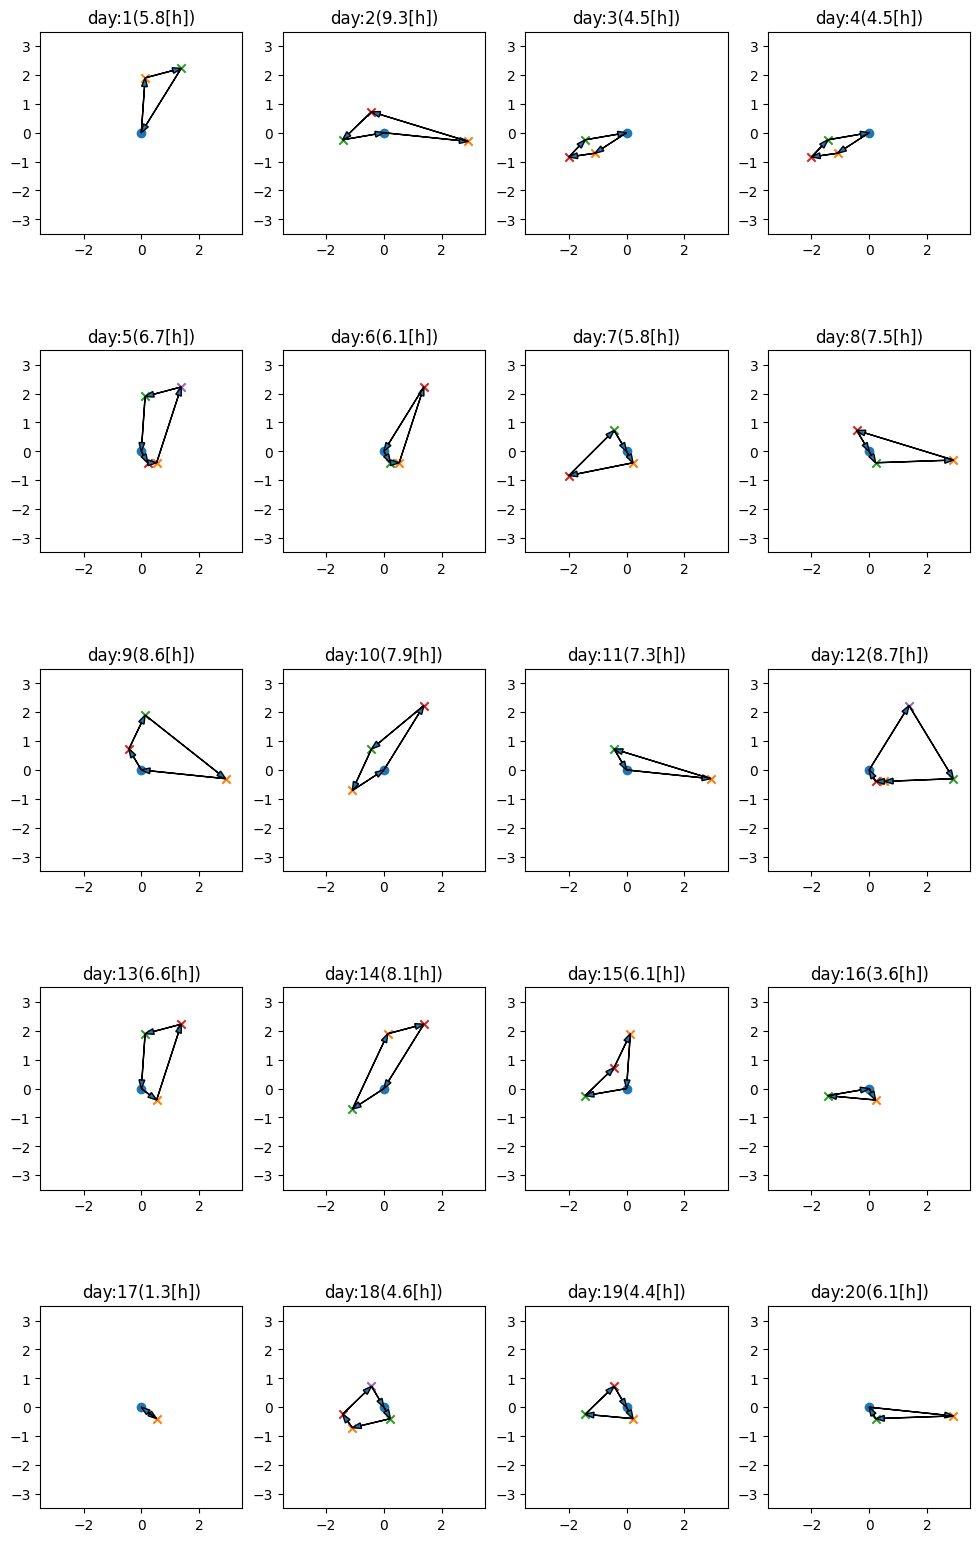

In [ ]:
import matplotlib.pyplot as plt

# 各地点の座標の取得
K2XY = {row.k:(row.x,row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(12,20))
for i in range(len(D)):
    d = D[i]
    tar_q = resD2Q[d]
    X = Q2X[tar_q]
    routeK = [k1 for k1,k2 in X]
    time = Q2T[tar_q]
    title_text = 'day:{}({:.1f}[h])'.format(d, time)

    ax = fig.add_subplot(5, 4, i + 1,
                         xlim=(-3.5, 3.5),
                         ylim=(-3.5, 3.5),
                         title=title_text)
    ax.set_aspect('equal')

    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker='o')
            else:
                ax.scatter(row.x, row.y, marker='x')

    for k1,k2 in X:
        (x1,y1) = K2XY[k1]
        (x2,y2) = K2XY[k2]
        ax.arrow(x1, y1, (x2 - x1), (y2 - y1),
                head_width=0.2,
                length_includes_head=True)

スッキリした配送ルート

### **5.7 第5章のまとめ**

省略。色々発展的な例題が出されているが、チャレンジできず。

どの課題もできる気がしない…